# Deep Learning & Art: Neural Style Transfer

Welcome to the Week 4 assignment! In this lab assignment, you will learn about Neural Style Transfer, an algorithm created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

**Upon completion of this assignment, you will be able to:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 
- Define the style cost function for Neural Style Transfer
- Define the content cost function for Neural Style Transfer

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. With Neural Style Transfer, you'll get to optimize a cost function to get pixel values. Exciting!

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader Error: Grader feedback not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/convolutional-neural-networks/supplement/DS4yP/h-ow-to-refresh-your-workspace).

## Table of Contents

- [1 - Packages](#1)
- [2 - Problem Statement](#2)
- [3 - Transfer Learning](#3)
- [4 - Neural Style Transfer (NST)](#4)
    - [4.1 - Computing the Content Cost](#4-1)
        - [4.1.1 - Make Generated Image G Match the Content of Image C](#4-1-1)
        - [4.1.2 - Content Cost Function  𝐽𝑐𝑜𝑛𝑡𝑒𝑛𝑡(𝐶,𝐺)](#4-1-2)
            - [Exercise 1 - compute_content_cost](#ex-1)
    - [4.2 - Computing the Style Cost](#4-2)
        - [4.2.1 - Style Matrix](#4-2-1)
            - [Exercise 2 - gram_matrix](#ex-2)
        - [4.2.2 - Style Cost](#4-2-2)
            - [Exercise 3 - compute_layer_style_cost](#ex-3)
        - [4.2.3 Style Weights](#4-2-3)
            - [Exercise 4 - compute_style_cost](#ex-4)
    - [4.3 - Defining the Total Cost to Optimize](#4-3)
        - [Exercise 5 - total_cost](#ex-5)
- [5 - Solving the Optimization Problem](#5)
    - [5.1 Load the Content Image](#5-1)
    - [5.2 Load the Style Image](#5-2)
    - [5.3 Randomly Initialize the Image to be Generated](#5-3)
    - [5.4 - Load Pre-trained VGG19 Model](#5-4)
    - [5.5 - Compute Total Cost](#5-5)
        - [5.5.1 - Compute Content Cost](#5-5-1)
        - [5.5.2 - Compute Style Cost](#5-5-2)
            - [Exercise 6 - train_step](#ex-6)
    - [5.6 - Train the Model](#5-6)
- [6 - Test With Your Own Image (Optional/Ungraded)](#6)
- [7 - References](#7)




<a name='1'></a>
## 1 - Packages

Run the following code cell to import the necessary packages and dependencies you will need to perform Neural Style Transfer.

In [1]:
### v1.1

In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from public_tests import *
%matplotlib inline

<a name='2'></a>
## 2 - Problem Statement

Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. 

In this assignment, you are going to combine the Louvre museum in Paris (content image C) with the impressionist style of Claude Monet (style image S) to generate the following image:

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's get started!

<a name='3'></a>
## 3 - Transfer Learning


Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

You will be using the eponymously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, you'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

In [3]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<a name='4'></a>
## 4 - Neural Style Transfer (NST)

Next, you will be building the Neural Style Transfer (NST) algorithm in three steps:

- First, you will build the content cost function $J_{content}(C,G)$
- Second, you will build the style cost function $J_{style}(S,G)$
- Finally, you'll put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. Exciting!

<a name='4-1'></a>
### 4.1 - Computing the Content Cost

<a name='4-1-1'></a>
#### 4.1.1 - Make Generated Image G Match the Content of Image C

One goal you should aim for when performing NST is for the content in generated image G to match the content of image C. To do so, you'll need an understanding of <b> shallow versus deep layers </b>:

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>. 

#### To choose a "middle" activation layer $a^{[l]}$ :
You need the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you will usually get the most visually pleasing results if you choose a layer from somewhere in the middle of the network--neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.
* After you have finished this exercise, feel free to come back and experiment with using different layers to see how the results vary!

#### To forward propagate image "C:"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, this was written as $a^{[l](C)}$, but here the superscript $[l]$ is dropped to simplify the notation.) This will be an $n_H \times n_W \times n_C$ tensor.

#### To forward propagate image "G":
* Repeat this process with the image G: Set G as the input, and run forward propagation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

In this running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


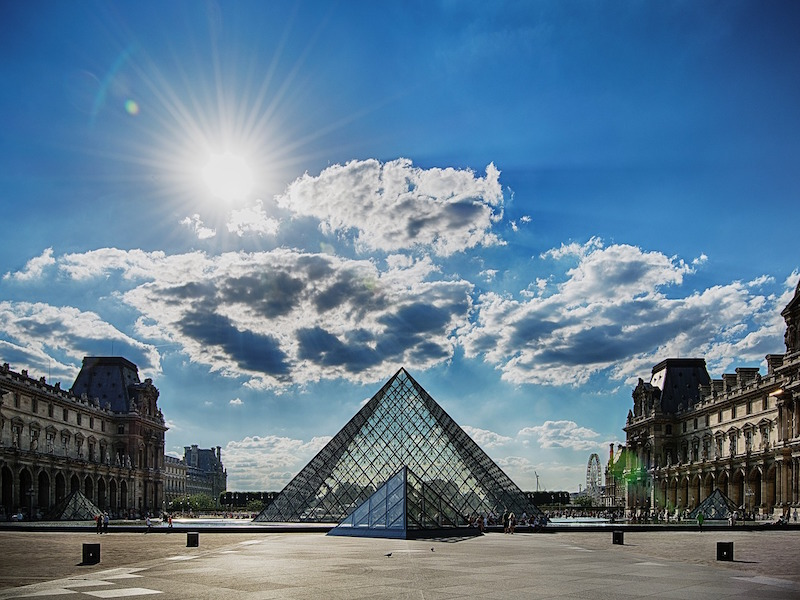

In [4]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

<a name='4-1-2'></a>
#### 4.1.2 - Content Cost Function $J_{content}(C,G)$
One goal you should aim for when performing NST is for the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

<a name='ex-1'></a>
### Exercise 1 - compute_content_cost

Compute the "content cost" using TensorFlow. 

**Instructions**: 

`a_G`: hidden layer activations representing content of the image G
<br>
`a_C`: hidden layer activations representing content of the image C 

The 3 steps to implement this function are:
1. Retrieve dimensions from `a_G`: 
    - To retrieve dimensions from a tensor `X`, use: `X.get_shape().as_list()`
2. Unroll `a_C` and `a_G` as explained in the picture above
    - You'll likely want to use these functions: [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) and [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape).
3. Compute the content cost:
    - You'll likely want to use these functions: [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract).
    
    
#### Additional Hints for "Unrolling"
* To unroll the tensor, you want the shape to change from $(m,n_H,n_W,n_C)$ to $(m, n_H \times n_W, n_C)$.
* `tf.reshape(tensor, shape)` takes a list of integers that represent the desired output shape.
* For the `shape` parameter, a `-1` tells the function to choose the correct dimension size so that the output tensor still contains all the values of the original tensor.
* So `tf.reshape(a_C, shape=[m, n_H * n_W, n_C])` gives the same result as `tf.reshape(a_C, shape=[m, -1, n_C])`.
* If you prefer to re-order the dimensions, you can use `tf.transpose(tensor, perm)`, where `perm` is a list of integers containing the original index of the dimensions. 
* For example, `tf.transpose(a_C, perm=[0,3,1,2])` changes the dimensions from $(m, n_H, n_W, n_C)$ to $(m, n_C, n_H, n_W)$.
<!-- * There is more than one way you can unroll a tensor.  -->
* Again, note that you don't necessarily need `tf.transpose` to 'unroll' the tensors in this case but this is a useful function to practice and understand for other situations that you'll encounter.


In [11]:
# UNQ_C1
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape 'a_C' and 'a_G' (≈2 lines)
    # DO NOT reshape 'content_output' or 'generated_output'
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled -  a_G_unrolled))/(4.0*n_H*n_W*n_C) 
    
    ### END CODE HERE
    
    return J_content

In [12]:
### you cannot edit this cell

compute_content_cost_test(compute_content_cost)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_content</b>  
        </td>
        <td>
            7.0568767
        </td>
    </tr>

</table>


Congrats! You've now successfully calculated the content cost function!

<br>
<font color = 'blue'>
    
**What you should remember:**
    
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When you minimize the content cost later, this will help make sure $G$ has similar content as $C$. 


<a name='4-2'></a>
### 4.2 - Computing the Style Cost

For the running example, you will use the following style image: 

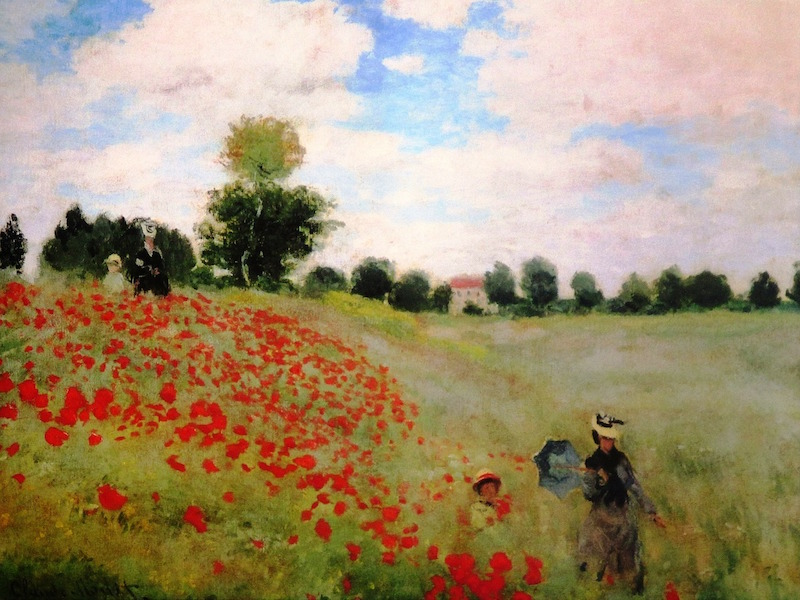

In [13]:
example = Image.open("images/monet_800600.jpg")
example

This was painted in the style of <b>[impressionism](https://en.wikipedia.org/wiki/Impressionism)</b>.

Now let's see how you can now define a "style" cost function $J_{style}(S,G)$!

<a name='4-2-1'></a>
#### 4.2.1 - Style Matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. Following the common terminology used in the literature: 
    * $G$ is used to denote the Style matrix (or Gram matrix) 
    * $G$ also denotes the generated image. 
* For the sake of clarity, in this assignment $G_{gram}$ will be used to refer to the Gram matrix, and $G$ to denote the generated image.


#### Compute Gram matrix $G_{gram}$
You will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

<a name='ex-2'></a>
### Exercise 2 - gram_matrix
* Using TensorFlow, implement a function that computes the Gram matrix of a matrix A. 
    * The formula is: The gram matrix of A is $G_A = AA^T$. 
* You may want to use these functions: [matmul](https://www.tensorflow.org/api_docs/python/tf/matmul) and [transpose](https://www.tensorflow.org/api_docs/python/tf/transpose).

In [14]:
# UNQ_C2
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    ### START CODE HERE
    
    #(≈1 line)
    GA = tf.matmul(A, tf.transpose(A))
    
    ### END CODE HERE

    return GA

In [15]:
### you cannot edit this cell

gram_matrix_test(gram_matrix)

GA = 
tf.Tensor(
[[ 63.193256  -26.729713   -7.732155 ]
 [-26.729713   12.775055   -2.5164719]
 [ -7.732155   -2.5164719  23.746586 ]], shape=(3, 3), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>GA</b>
        </td>
        <td>
           [[ 63.193256  -26.729713   -7.732155 ] <br>
 [-26.729713   12.775055   -2.5164719] <br>
 [ -7.732155   -2.5164719  23.746586 ]] <br>
        </td>
    </tr>

</table>

<a name='4-2-2'></a>
#### 4.2.2 - Style Cost

You now know how to calculate the Gram matrix. Congrats! Your next goal will be to minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* For now, you will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Make sure you remember that this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$


<a name='ex-3'></a>
### Exercise 3 - compute_layer_style_cost
Compute the style cost for a single layer. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G: 
    - To retrieve dimensions from a tensor X, use: `X.get_shape().as_list()`
2. Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above (see the images in the sections "computing the content cost" and "style matrix").
    - You may use [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) and [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape).
3. Compute the Style matrix of the images S and G. (Use the function you had previously written.) 
4. Compute the Style cost:
    - You may find [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract) useful.
    
    
#### Additional Hints
* Since the activation dimensions are $(m, n_H, n_W, n_C)$ whereas the desired unrolled matrix shape is $(n_C, n_H*n_W)$, the order of the filter dimension $n_C$ is changed.  So `tf.transpose` can be used to change the order of the filter dimension.


In [30]:
# UNQ_C3
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, shape = [-1, n_C] ))
    a_G = tf.transpose(tf.reshape(a_G, shape = [-1, n_C] ))
    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum((GS-GG)**2)/(4*(n_C*n_H*n_W)**2)
    
    ### END CODE HERE
    
    return J_style_layer

In [31]:
### you cannot edit this cell

compute_layer_style_cost_test(compute_layer_style_cost)

J_style_layer = tf.Tensor(14.01649, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_style_layer</b>
        </td>
        <td>
           14.01649
        </td>
    </tr>

</table>

<a name='4-2-3'></a>
#### 4.2.3 Style Weights

* So far you have captured the style from only one layer. 
* You'll get better results if you "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$.
* By default, give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

Start by listing the layer names:

In [32]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Get a look at the output of a layer `block5_conv4`. You will later define this as the content layer, which will represent the image.

In [33]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

Now choose layers to represent the style of the image and assign style costs:

In [34]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


<a name='ex-4'></a>
### Exercise 4 -  compute_style_cost
Compute style cost

<b> Instructions: </b>
* A compute_style_cost(...) function has already been implemented. 
* It calls your `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`. 
* Please read over it to make sure you understand what it's doing. 

#### Description of `compute_style_cost`
For each layer:
* Select the activation (the output tensor) of the current layer.
* Get the style of the style image "S" from the current layer.
* Get the style of the generated image "G" from the current layer.
* Compute the "style cost" for the current layer
* Add the weighted style cost to the overall style cost (J_style)

Once you're done with the loop:  
* Return the overall style cost.

In [35]:
### you cannot edit this cell

def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

How do you choose the coefficients for each layer? The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.



<br>
<font color = 'blue'>
    
**What you should remember:**
    
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. 
- You get even better results by combining this representation from multiple different layers. 
- This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 
   



<a name='4-3'></a>
### 4.3 - Defining the Total Cost to Optimize

Finally, you will create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

<a name='ex-5'></a>
### Exercise 5 - total_cost

Implement the total cost function which includes both the content cost and the style cost. 

In [36]:
# UNQ_C4
# GRADED FUNCTION: total_cost
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    ### START CODE HERE
    
    #(≈1 line)
    J = alpha* J_content + beta*J_style
    
    ### START CODE HERE

    return J

In [37]:
### you cannot edit this cell

total_cost_test(total_cost)

J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J</b>
        </td>
        <td>
           32.9832
        </td>
    </tr>

</table>

<font color = 'blue'>
    
**What you should remember:**
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$.
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

<a name='5'></a>
## 5 - Solving the Optimization Problem

Finally, you get to put everything together to implement Neural Style Transfer!


Here's what your program be able to do:

1. Load the content image 
2. Load the style image
3. Randomly initialize the image to be generated 
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

Here are the individual steps in detail.

<a id='part(4)'></a>

<a name='5-1'></a>
### 5.1 Load the Content Image
Run the following code cell to load, reshape, and normalize your "content" image C (the Louvre museum picture):

(1, 400, 400, 3)


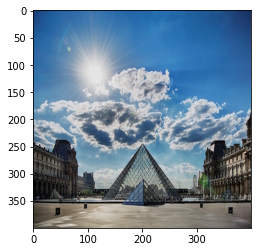

In [38]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### 5.2 Load the Style Image
Now load, reshape and normalize your "style" image (Claude Monet's painting):

(1, 400, 400, 3)


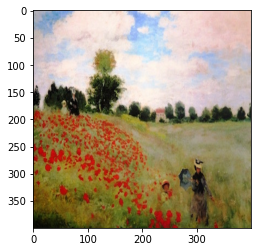

In [39]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### 5.3 Randomly Initialize the Image to be Generated
Now, you get to initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

(1, 400, 400, 3)


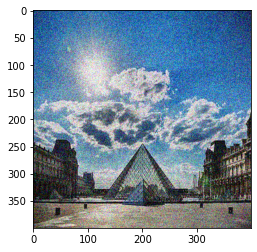

In [40]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## 5.4 - Load Pre-trained VGG19 Model
Next, as explained in [part(2)](#part(2)), define a function which loads the VGG19 model and returns a list of the outputs for the middle layers.

In [41]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Now, define the content layer and build the model.

In [42]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separate variables.

In [43]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

<a name='5-5'></a>
### 5.5 - Compute Total Cost

<a name='5-5-1'></a>
#### 5.5.1 - Compute the Content image Encoding (a_C)

You've built the model, and now to compute the content cost, you will encode your content image using the appropriate hidden layer activations. Set this encoding to the variable `a_C`. Later in the assignment, you will need to do the same for the generated image, by setting the variable `a_G` to be the appropriate hidden layer activations. You will use layer `block5_conv4` to compute the encoding. The code below does the following:

1. Set a_C to be the tensor giving the hidden layer activation for layer "block5_conv4" using the content image.

In [44]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

<a name='5-5-2'></a>
#### 5.5.2 - Compute the Style image Encoding (a_S) 

The code below sets a_S to be the tensor giving the hidden layer activation for `STYLE_LAYERS` using our style image.

In [45]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils that you will need to display the images generated by the style transfer model.

In [46]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<a name='ex-6'></a>
### Exercise 6 - train_step 

Implement the train_step() function for transfer learning

* Use the Adam optimizer to minimize the total cost `J`.
* Use a learning rate of 0.01
* [Adam Optimizer documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
* You will use [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to update the image. ([Course 2 Week 3: TensorFlow Introduction Assignment](https://www.coursera.org/learn/deep-neural-network/programming/fuJJY/tensorflow-introduction))
* Within the tf.GradientTape():
   * Compute the encoding of the generated image using vgg_model_outputs. Assign the result to a_G.
   * Compute the total cost J, using the global variables a_C, a_S and the local a_G
   * Use `alpha = 10` and `beta = 40`.

In [53]:
# UNQ_C5
# GRADED FUNCTION: train_step

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        
        ### START CODE HERE
        
        # Compute a_G as the vgg_model_outputs for the current generated image
        #(1 line)
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        alpha = 10
        beta=40
        J = total_cost(J_content, J_style, alpha = alpha, beta=beta)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [54]:
### you cannot edit this cell

# You always must run the last cell before this one. You will get an error if not.

generated_image = tf.Variable(generated_image)

train_step_test(train_step, generated_image)

tf.Tensor(25700.346, shape=(), dtype=float32)
tf.Tensor(17778.377, shape=(), dtype=float32)
All tests passed


**Expected output**
```
tf.Tensor(25700.346, shape=(), dtype=float32)
tf.Tensor(17778.389, shape=(), dtype=float32)
```

Looks like it's working! Now you'll get to put it all together into one function to better see your results!

<a name='5-6'></a>
### 5.6 - Train the Model

Run the following cell to generate an artistic image. It should take about 3min on a GPU for 2500 iterations. Neural Style Transfer is generally trained using GPUs.

If you increase the learning rate you can speed up the style transfer, but often at the cost of quality.

Epoch 0 


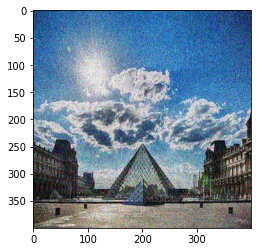

Epoch 250 


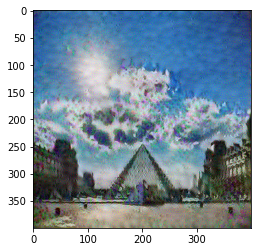

Epoch 500 


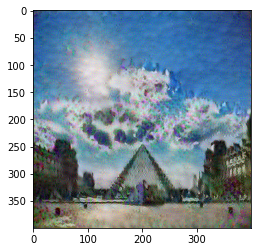

Epoch 750 


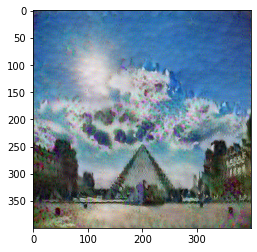

Epoch 1000 


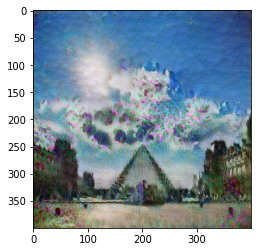

Epoch 1250 


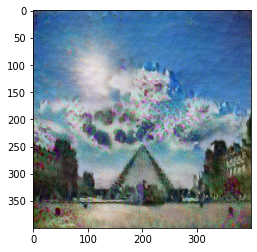

Epoch 1500 


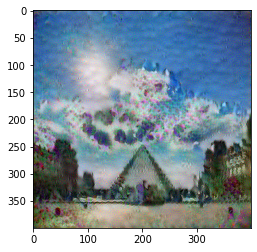

Epoch 1750 


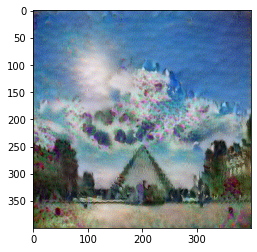

Epoch 2000 


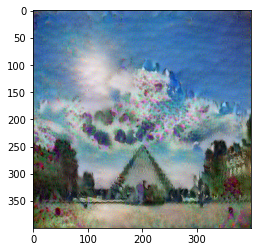

In [ ]:
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

Now, run the following code cell to see the results!

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

Look at that! You did it! After running this, in the upper bar of the notebook click on "File" and then "Open". Go to the "/output" directory to see all the saved images. Open "generated_image" to see the generated image! :)

Running for around 20000 epochs with a learning rate of 0.001, you should see something like the image presented below on the right:

<img src="images/louvre_generated.png" style="width:800px;height:300px;">

The hyperparameters were set so that you didn't have to wait too long to see an initial result. To get the best looking results, you may want to try running the optimization algorithm longer (and perhaps with a smaller learning rate). After completing and submitting this assignment, come back and play more with this notebook, and see if you can generate even better looking images. But first, give yourself a pat on the back for finishing this long assignment!

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;height:300px;">

## Free Up Resources for Other Learners

If you don't plan on continuing to the next `Optional` section, help us to provide our learners a smooth learning experience, by freeing up the resources used by your assignment by running the cell below so that the other learners can take advantage of those resources just as much as you did. Thank you!

**Note**: 
- Run the cell below when you are done with the assignment and are ready to submit it for grading.
- When you'll run it, a pop up will open, click `Ok`.
- Running the cell will `restart the kernel`.

In [ ]:
%%javascript
IPython.notebook.save_checkpoint();
if (confirm("Clear memory?") == true)
{
    IPython.notebook.kernel.restart();
}

<a name='6'></a>
## 6 - Test With Your Own Image (Optional/Ungraded)

Finally, you can also rerun the algorithm on your own images! 

To do so, go back to part(4) and change the content image and style image with your own pictures. In detail, here's what you should do:

1. Click on "File -> Open" in the upper tab of the notebook
2. Go to "/images" and upload your images (images will scaled to 400x400, but you can change that parameter too in section 2), rename them "my_content.png" and "my_style.png" for example.
3. Change the code in [part(4)](#part(4)) from :

```py
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))

```

&emsp;&emsp;to:

``` py
content_image = np.array(Image.open("images/my_content.jpg").resize((img_size, img_size)))
style_image =  np.array(Image.open("my_style.jpg").resize((img_size, img_size)))

```
4. Rerun the cells (you may need to restart the Kernel in the upper tab of the notebook).

You can share your generated images with us on social media with the hashtag #deeplearningAI or by tagging us directly!

Here are some ideas on how to tune your hyperparameters: 
- To select different layers to represent the style, redefine `STYLE_LAYERS`
- To alter the number of iterations you want to run the algorithm, try changing `epochs` given in Section 5.6.
- To alter the relative weight of content versus style, try altering alpha and beta values

Happy coding!

## Free Up Resources for Other Learners

In order to provide our learners a smooth learning experience, please free up the resources used by your assignment by running the cell below so that the other learners can take advantage of those resources just as much as you did. Thank you!

**Note**: 
- Run the cell below when you are done with the assignment and are ready to submit it for grading.
- When you'll run it, a pop up will open, click `Ok`.
- Running the cell will `restart the kernel`.

In [ ]:
%%javascript
IPython.notebook.save_checkpoint();
if (confirm("Clear memory?") == true)
{
    IPython.notebook.kernel.restart();
}

### Conclusion

Great job on completing this assignment! You are now able to use Neural Style Transfer to generate artistic images. This is also your first time building a model in which the optimization algorithm updates the pixel values rather than the neural network's parameters. Deep learning has many different types of models and this is only one of them! 

<font color = 'blue'>
    
## What you should remember
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 




# Congratulations on finishing the course!
This was the final programming exercise of this course. Congratulations - you've finished all the programming exercises of this course on Convolutional Networks! See you in Course 5, Sequence Models! 


<a name='7'></a>
## 7 - References

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups this lab was inspired by. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
